In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [2]:
import os
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.data import Dataset


tf.enable_eager_execution()

print('tensorflow version: ', tf.VERSION)

tensorflow version:  1.14.0


In [3]:
meta_size = (800, 400)


def load_data():
  images = [Image.open('drive/My Drive/Data/test_image1.jpg').resize(meta_size),
            Image.open('drive/My Drive/Data/test_image2.jpg').resize(meta_size)]
  images = [np.array(img) for img in images]
  with open('drive/My Drive/Data/labels.json') as f:
    labels = []
    for i, l in enumerate(json.load(f)):
      bboxes = []
      for bbox in l['bboxes']:
        x1, y1 = bbox['p1']['x'], bbox['p1']['y']
        # x1 = x1 / meta_size[0] * images[i].shape[1]
        # y1 = y1 / meta_size[1] * images[i].shape[0]
        x2, y2 = bbox['p2']['x'], bbox['p2']['y']
        # x2 = x2 / meta_size[0] * images[i].shape[1]
        # y2 = y2 / meta_size[1] * images[i].shape[0]
        x3, y3 = bbox['p3']['x'], bbox['p3']['y']
        # x3 = x3 / meta_size[0] * images[i].shape[1]
        # y3 = y3 / meta_size[1] * images[i].shape[0]
        x4, y4 = bbox['p4']['x'], bbox['p4']['y']
        # x4 = x4 / meta_size[0] * images[i].shape[1]
        # y4 = y4 / meta_size[1] * images[i].shape[0]
        
        bboxes.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
      labels.append(bboxes)
  return np.array(images), np.array(labels)


images, labels = load_data()
print(images[0].shape)
print(labels[0].shape)
print(images[1].shape)
print(labels[1].shape)

(400, 800, 3)
(13, 4, 2)
(400, 800, 3)
(13, 4, 2)


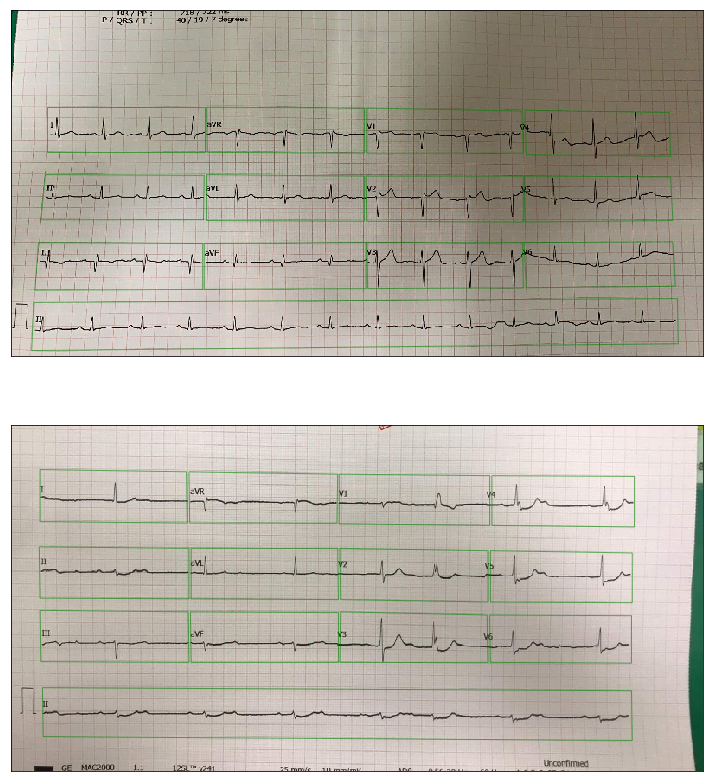

In [4]:
def draw_bboxes(label):
  ax = plt.gca()
  for bbox in label:
    xy = np.array(bbox)
    poly = patches.Polygon(xy, alpha=0.6, facecolor='none', edgecolor='green')
    ax.add_patch(poly)


plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
plt.imshow(images[0])
plt.xticks([])
plt.yticks([])
draw_bboxes(labels[0])

plt.subplot(2, 1, 2)
plt.imshow(images[1])
plt.xticks([])
plt.yticks([])
draw_bboxes(labels[1])

plt.show()

In [5]:
def conv2d(x, units, ksize, strides, dropout=0.0):
  x = layers.Conv2D(units, ksize, strides=strides, padding='same', use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  if dropout:
    x = layers.Dropout(dropout)(x)
  x = layers.ReLU()(x)
  return x


def residual(x, units, ksize):
  input_x = x
  x = conv2d(x, units, ksize, 1)
  x = conv2d(x, units, ksize, 1)
  x = layers.Add()([x, input_x])
  return x


def build_model():
  # resnet18
  inputs = layers.Input(shape=[meta_size[1], meta_size[0], 3])
  scaled = layers.Lambda(lambda x: x / 255.0)(inputs)  # 400x800x3
  
  x = conv2d(scaled, 64, 7, 2)  # 200x400x64
  x = layers.MaxPool2D(3, 2, padding='same')(x)  # 100x200x64
  
  x = residual(x, 64, 3)  # 100x200x64
  x = residual(x, 64, 3)  # 100x200x64
  
  x = conv2d(x, 128, 3, 2)  # 50x100x128
  x = conv2d(x, 128, 3, 1)  # 50x100x128
  x = residual(x, 128, 3)  # 50x100x128
  
  x = conv2d(x, 256, 3, 2)  # 25x50x256
  x = conv2d(x, 256, 3, 1)  # 25x50x256
  x = residual(x, 256, 3)  # 25x50x256
  
  x = conv2d(x, 512, 3, 2)  # 13x25x512
  x = conv2d(x, 512, 3, 1)  # 13x25x512
  x = residual(x, 512, 3)  # 13x25x512
  
  # x = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1))(x)
  x = conv2d(x, 1024, 3, 1)  # 13x25x16
  x = conv2d(x, 16, 3, 1)  # 13x25x16
  x = layers.Flatten()(x)
  x = layers.Dense(13 * 8)(x)
  x = layers.Reshape([13, 4, 2])(x)
  model = Model(inputs=[inputs], outputs=[x])
  return model


K.clear_session()
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 800, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 400, 800, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 400, 64) 9408        lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 400, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

(32, 400, 800, 3)
(32, 13, 4, 2)


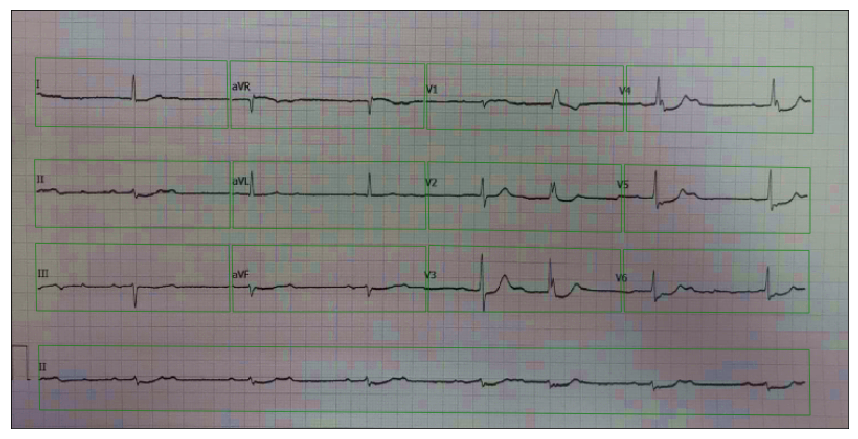

In [6]:
def scale_label(image, label, image_size):
  l = np.array(label)
  l[:, :, 0] /= image_size[0]
  l[:, :, 1] /= image_size[1]
  return l


def random_crop_image(image, label):
  x1 = np.min(label[:, :, 0])
  y1 = np.min(label[:, :, 1])
  x2 = np.max(label[:, :, 0])
  y2 = np.max(label[:, :, 1])
  
  rx1 = np.random.randint(0, int(x1))
  ry1 = np.random.randint(0, int(y1))
  rx2 = np.random.randint(int(x2), image.shape[1])
  ry2 = np.random.randint(int(y2), image.shape[0])
  
  new_label = label.copy()
  new_label[:, :, 0] -= rx1
  new_label[:, :, 1] -= ry1

  img = image[ry1:ry2, rx1:rx2, :].copy()
  img = cv2.resize(img, meta_size)
  return img, new_label, (rx2 - rx1, ry2 - ry1)


def random_process_image(image,
                         change_hue_prob=0.33,
                         gray_prob=0.33,
                         change_brightness_prob=0.5,
                         gamma=20.0,
                         alpha1=1.01,
                         alpha2=0.7,
                         beta=10.0):
  img = image.copy()
  
  if np.random.random() < change_hue_prob:
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    new_h = hsv[:, :, 0] + hsv[:, :, 0] * np.random.randn() * gamma
    new_h = np.clip(new_h, 0, 255).astype(np.uint8)
    hsv[:, :, 0] = new_h
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
  elif np.random.random() < gray_prob:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.copy()
    img[:, :, 0] = gray
    img[:, :, 1] = gray
    img[:, :, 2] = gray
    
  if np.random.random() < change_brightness_prob:
    # img = (1.0 + alpha * np.random.randn()) * img + \
    #     beta * np.random.randn()
    # img = (1.0 + alpha) * img + beta
    # img = (alpha2) * img - beta
    img = (alpha2 + (alpha1 - alpha2) * np.random.random()) * img + beta * np.random.randn()
    img = np.clip(img, 0, 255).astype(np.uint8)
  return img
  


def create_generator(images, labels, batch_size=32, crop_prob=0.66):
  datasize = len(images)
  while True:
    batch_images = []
    batch_labels = []
    for _ in range(batch_size):
      index = np.random.randint(0, datasize)
      img = images[index]
      
      if np.random.random() < crop_prob:
        lb = labels[index]
        img, lb, image_size = random_crop_image(img, lb)
      else:
        lb = labels[index]
        image_size = (img.shape[1], img.shape[0])
      
      lb = scale_label(img, lb, image_size)
      img = random_process_image(img)
      batch_images.append(img)
      batch_labels.append(lb)
    
    batch_images = np.array(batch_images)
    batch_labels = np.array(batch_labels)
    
    yield batch_images, batch_labels


def visualize(x, y):
  plt.imshow(x[0])
  ax = plt.gca()
  plt.xticks([])
  plt.yticks([])
  
  for bbox in y[0]:
    xy = bbox.copy()
    xy[:, 0] *= x[0].shape[1]
    xy[:, 1] *= x[0].shape[0]
    poly = patches.Polygon(xy, alpha=0.6, facecolor='none', edgecolor='green')
    ax.add_patch(poly)


batch_size = 16
generator = create_generator(images, labels, batch_size=batch_size)
x, y = next(generator)

print(x.shape)
print(y.shape)

plt.figure(figsize=(15, 15))
visualize(x, y)
plt.show()

just double check make sure its still correct

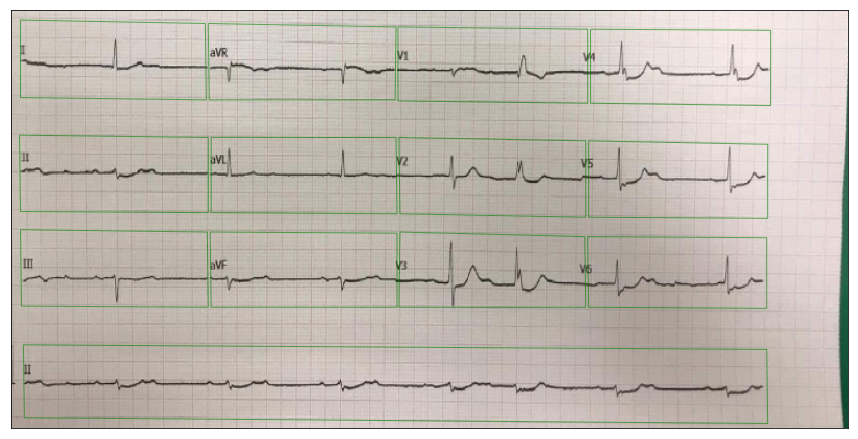

In [7]:
x, y = next(generator)

plt.figure(figsize=(15, 15))
visualize(x, y)
plt.show()

In [0]:
model.load_weights('drive/My Drive/Data/graph_detection.h5')

In [8]:
def schedule(epoch, current_lr):
  if epoch == 5:
    return 3e-5
  if epoch == 10:
    return 1e-5
  if epoch == 15:
    return 3e-6
  return current_lr


model.compile(optimizer=tf.keras.optimizers.Adam(2e-4),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])


history = model.fit_generator(generator,
                              epochs=20,
                              steps_per_epoch=1000,
                              callbacks=[callbacks.LearningRateScheduler(schedule, verbose=1)])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 1/20
1000/1000 [==============================] - 1295s 1s/step - loss: 0.0052 - mean_absolute_error: 0.0330

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 2/20
1000/1000 [==============================] - 1280s 1s/step - loss: 2.7978e-04 - mean_absolute_error: 0.0126

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 3/20
1000/1000 [==============================] - 1279s 1s/step - loss: 1.7565e-04 - mean_absolute_error: 0.0102

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 4/20
1000/1000 [==============================] - 1278s 1s/step - loss: 1.5605e-04 - mean_absolute_error: 0.0094

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 5/20
1000/1000 [==============================] - 1277s 1s/step - loss: 8.1837e-05 - mean_ab

In [0]:
model.save('drive/My Drive/Data/graph_detection.h5')

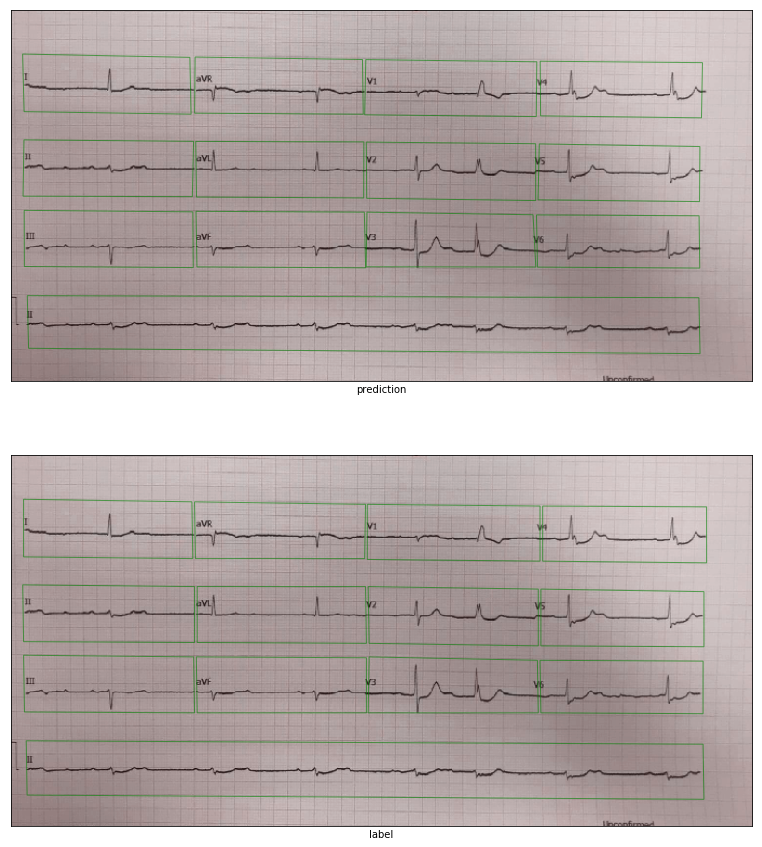

In [10]:
def evaluate():
  x, y = next(generator)
  
  p = model.predict(x)
  
  plt.figure(figsize=(15, 15))
  plt.subplot(2, 1, 1)
  visualize(x, p)
  plt.xlabel('prediction')
  
  plt.subplot(2, 1, 2)
  visualize(x, y)
  plt.xlabel('label')
  
  plt.show()
  

evaluate()

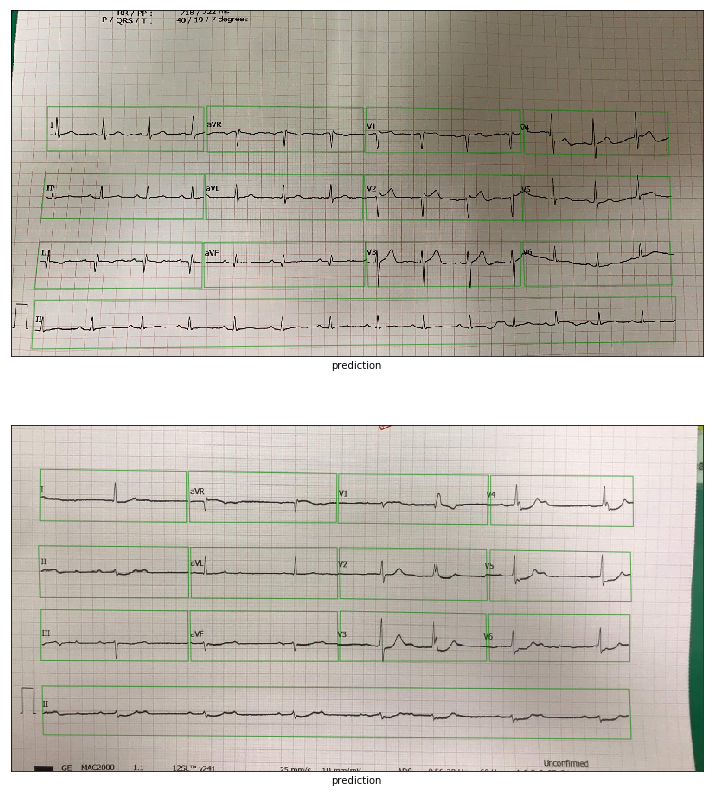

In [14]:
def evaluate2():
  p = model.predict(images)
  
  plt.figure(figsize=(14, 14))
  plt.subplot(2, 1, 1)
  visualize(images, p)
  plt.xlabel('prediction')
  
  plt.subplot(2, 1, 2)
  visualize(images[1:], p[1:])
  plt.xlabel('prediction')
  
  plt.show()
  

evaluate2()